## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [34]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score
import seaborn as sn

## Defining hot encoding and decoding Functions

In [42]:
def hotencode(arr):
    a = np.zeros([len(arr), np.max(arr)])
    for i in range(len(arr)):
        col = arr[i]
        a[i,col-1] = 1
    return a
    # invert first example
    # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
    # print(inverted)

def hotdecode(arr):
    a = []
    for i in range(len(arr)):
        a.append(np.argmax(arr[i,:])+1)
    return np.asarray(a)
    

## Part 1 - Loading dataset and Text Preprocessing
_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

In [3]:
path_json = 'data/docs'
path_csv = 'data'
file_csv = os.path.join(path_csv, 'document_departments.csv')

In [4]:
# Loading csv files
data = pd.read_csv(file_csv)
data.head(5)

,Document ID,Department
0,8196431,Customer service
1,8278123,Digital Marketing
2,8331625,Sales
3,8331003,Back office ticketing
4,8277939,Digital Marketing


In [5]:
# Total number of datapoints
print('Total number of dataset available %d'%(len(data)))

Total number of dataset available 1162


In [7]:
# Loading Json object for readability
obj = json.load(open(os.path.join(path_json, str(data['Document ID'][78]) + '.json')))
obj

{'company_info': {'Company Description': "cmts is engaged in the data entry outsourcing and supply of skilled/semi skilled &amp; unskilled Manpower across the industry spectrum. Our pool of manpower ranges from professionals such as Sales &amp; technical professionals in different categories, IT professionals, aviation sector, technical profiles, engineers, non-technical in-house professionals, administrative profiles, Accountant, HR, Back office, Data Entry Operator etc. Our organization's goal is total clients satisfaction through quality and personalized delivery of each and every service. We therefore exist to cater the need of these prospecting employers/companies since our inception in 2008.",
  'Email': 'hr@cmts.in',
  'Company Name': 'CMTS (Core Management &amp; Technical Services)',
  'Telephone': '9631857963'},
 'api_data': {'job_location': ['Ludhiana'],
  'jd_id': '6600981',
  'job_keywords': ['Ticketing Executive for Tavel Company at Saanewal Ludhiana'],
  'job_industry': '

Useful Attributes
1. job_keywords
2. job_title
3. Skills
4. Department

In [9]:
# Number of Major attributes in JSON object
print('Number of attributes: %d'%(len(obj.keys())))

Number of attributes: 6


### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

### Counting datapoints from different department

In [10]:
data['count'] = data['Department'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = data.groupby('Department').agg({'count': 'sum'}).reset_index()

In [11]:
unique_img_ids.head()

,Department,count
0,Administration,38
1,Airline Ground Operations,4
2,Analytics,9
3,Back office ticketing,18
4,Content,6


### Creating a Hashmap of Departments and labels

In [13]:
unique_img_ids['Department'].values

array(['Administration', 'Airline Ground Operations', 'Analytics',
       'Back office ticketing', 'Content', 'Customer service',
       'Data entry', 'Digital Marketing',
       'Engineering Design Construction', 'Finance', 'Flight Operations',
       'IT', 'Learning and Development ', 'Logistics', 'Maintenance',
       'Management Consulting', 'Marine Deck ', 'Marine Engineering ',
       'Marine Service Steward ', 'Marketing', 'Operations', 'Presales ',
       'Procurement', 'Public Relations ', 'QA ', 'Recruitment',
       'Safety ', 'Sales', 'Technology', 'Ticketing'], dtype=object)

In [14]:
depart_map = {}
for i in range(len(unique_img_ids)):
    depart_map[unique_img_ids['Department'][i]] = i+1

In [15]:
# Number of different departments
print('Number of departments: %d'%(len(unique_img_ids)))

Number of departments: 30


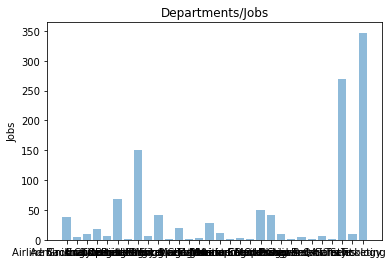

In [16]:
# Plotting number of jobs in different departments
y_pos = np.arange(len(unique_img_ids))
objects = unique_img_ids['Department']
performance = unique_img_ids['count']
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jobs')
plt.title('Departments/Jobs')

plt.show()

### Selecting important atttributes
1. Department
2. JobTitle
3. JobKeywords

In [18]:
n = len(data)
label = []
keyword = []

In [19]:
# Creating a new dataframe for selected attributes only
for i in range(n):
    obj = json.load(open(os.path.join(path_json, str(data['Document ID'][i]) + '.json')))
    department = obj['other_details']['Department:']
    title = obj['api_data']['job_title']
    obj = obj['api_data']['job_keywords']
    
    st = [st.strip(' ') for st in obj]
    dp = [dp.strip(' ') for dp in department]
    tt = [tt.strip(' ') for tt in title]
    st = st + dp + tt
    
    str_join = ",".join(st)
    label.append(depart_map[data['Department'][i]])
    keyword.append(str_join)

### Creating a new dataframe from selected attributes and their respective labels

In [20]:
df = []
df = pd.DataFrame(label, columns=['label'])
df.head()

,label
0,6
1,8
2,28
3,4
4,8


In [21]:
df2 = pd.DataFrame(keyword, columns=['keyword'])
df2.head()

,keyword
0,"telesales,telemarketing,communication,call cen..."
1,"internet media,facebook marketing,online adver..."
2,"immigration,canada pr,australia pr,client serv..."
3,"documentation,,Back Office Operations,F,r,e,s,..."
4,"internet media,facebook marketing,online adver..."


In [22]:
df = df.merge(df2, left_index=True, right_index=True)
df.head()

,label,keyword
0,6,"telesales,telemarketing,communication,call cen..."
1,8,"internet media,facebook marketing,online adver..."
2,28,"immigration,canada pr,australia pr,client serv..."
3,4,"documentation,,Back Office Operations,F,r,e,s,..."
4,8,"internet media,facebook marketing,online adver..."


In [23]:
x = df['keyword'].values
y = df['label'].values

### Data Imbalance Situation
Here we can clearly see that data classes given are not uniform. This is dealt in the later section

In [52]:
df['label'].value_counts()

30    347
28    270
8     151
6      69
20     50
10     42
21     41
1      38
15     28
12     20
4      18
16     12
29     10
22     10
3       9
9       7
26      6
5       6
24      5
2       4
18      3
14      3
17      2
19      2
25      2
7       2
11      2
13      1
23      1
27      1
Name: label, dtype: int64

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

Spliting dataset into Training and Testing

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [25]:
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

size of x_train (871,), x_test (291,), y_train (871,), y_test (291,)


### Vectorization of words
Generating feature vector

In [26]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)
X_train

<871x1302 sparse matrix of type '<class 'numpy.int64'>'
	with 9292 stored elements in Compressed Sparse Row format>

Hotencoding of labels

In [43]:
y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)

## Number of Classifiers

### 1. Logistic Regression

In [45]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train, y_train)
score = logistic.score(X_test, y_test)

print("Accuracy of Logistic classifier:", round(score,4)*100)

Accuracy of Logistic classifier: 90.38000000000001


### 2. Stochastic Gradient Descent

In [29]:
sgd = sklearn.linear_model.SGDClassifier(class_weight='balanced')
sgd.fit(X_train, y_train)
score = sgd.score(X_test, y_test)

print("Accuracy of sgd classifier:", round(score,4)*100)

Accuracy of sgd classifier: 84.19


### 3. Decision Tree

In [46]:
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
score = tree.score(X_test, y_test)

print("Accuracy of tree classifier:", round(score,4)*100)

Accuracy of tree classifier: 85.22


### 4. Random Forest

In [47]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
score = forest.score(X_test, y_test)

print("Accuracy of forest classifier:", round(score,4)*100)

Accuracy of forest classifier: 86.25


In [50]:
y_pred = forest.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

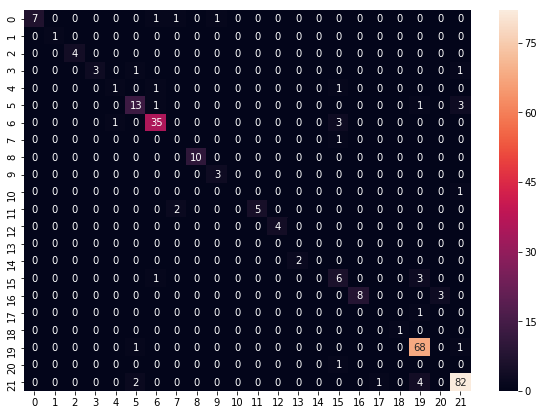

In [51]:
index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### 5. Simple Neural Network

In [32]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [33]:
model.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                12740     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
Total params: 13,070
Trainable params: 13,070
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train_hot,
                 epochs=100,
                 verbose=True,
                 validation_data=(X_test, y_test_hot),
                 batch_size=10)

Instructions for updating:
Use tf.cast instead.
Train on 871 samples, validate on 291 samples
Epoch 1/100
871/871 [==============================] - 1s 1ms/step - loss: 3.3083 - acc: 0.4018 - val_loss: 3.1794 - val_acc: 0.6151
Epoch 2/100
871/871 [==============================] - 0s 504us/step - loss: 2.9135 - acc: 0.6659 - val_loss: 2.6686 - val_acc: 0.6323
Epoch 3/100
871/871 [==============================] - 0s 526us/step - loss: 2.2240 - acc: 0.6211 - val_loss: 2.0426 - val_acc: 0.5739
Epoch 4/100
871/871 [==============================] - 1s 687us/step - loss: 1.6282 - acc: 0.6234 - val_loss: 1.6476 - val_acc: 0.6357
Epoch 5/100
871/871 [==============================] - 0s 556us/step - loss: 1.2208 - acc: 0.7141 - val_loss: 1.3789 - val_acc: 0.6907
Epoch 6/100
871/871 [==============================] - 0s 477us/step - loss: 0.9724 - acc: 0.7899 - val_loss: 1.2357 - val_acc: 0.7354
Epoch 7/100
871/871 [==============================] - 1s 663us/step - loss: 0.8123 - acc: 0.8140 

Epoch 61/100
871/871 [==============================] - 0s 558us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 62/100
871/871 [==============================] - 0s 551us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 63/100
871/871 [==============================] - 0s 515us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 64/100
871/871 [==============================] - 0s 494us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 65/100
871/871 [==============================] - 1s 607us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 66/100
871/871 [==============================] - 0s 461us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 67/100
871/871 [==============================] - 0s 471us/step - loss: nan - acc: 0.0402 - val_loss: nan - val_acc: 0.0103
Epoch 68/100
871/871 [==============================] - 0s 560us/step - loss: nan - acc: 0

In [37]:
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.0103


In [192]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


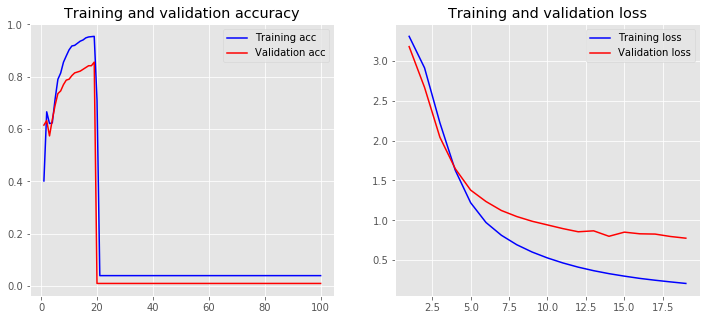

In [39]:
plot_history(history)

### 6. Neural Network with text tokenization

In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

In [41]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [42]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           65550     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                175035    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1080      
Total params: 241,665
Trainable params: 241,665
Non-trainable params: 0
_________________________________________________________________


Train on 871 samples, validate on 291 samples
Epoch 1/20
871/871 [==============================] - 2s 2ms/step - loss: 0.2427 - acc: 0.9157 - val_loss: 0.1079 - val_acc: 0.9695
Epoch 2/20
871/871 [==============================] - 1s 926us/step - loss: 0.0890 - acc: 0.9748 - val_loss: 0.0832 - val_acc: 0.9802
Epoch 3/20
871/871 [==============================] - 1s 934us/step - loss: 0.0669 - acc: 0.9832 - val_loss: 0.0716 - val_acc: 0.9824
Epoch 4/20
871/871 [==============================] - 1s 1ms/step - loss: 0.0538 - acc: 0.9859 - val_loss: 0.0638 - val_acc: 0.9832
Epoch 5/20
871/871 [==============================] - 1s 887us/step - loss: 0.0435 - acc: 0.9881 - val_loss: 0.0588 - val_acc: 0.9842
Epoch 6/20
871/871 [==============================] - 1s 963us/step - loss: 0.0359 - acc: 0.9901 - val_loss: 0.0553 - val_acc: 0.9847
Epoch 7/20
871/871 [==============================] - 1s 860us/step - loss: 0.0292 - acc: 0.9915 - val_loss: 0.0547 - val_acc: 0.9849
Epoch 8/20
871/871 [

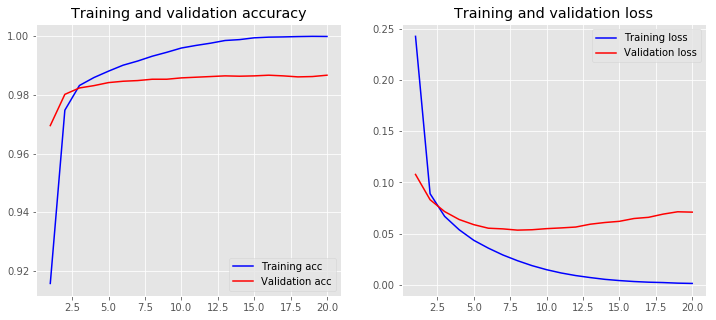

In [43]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [44]:
y_pred = model.predict(X_test)

In [45]:
y_pred = hotdecode(y_pred)

In [46]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [50]:
cm=confusion_matrix(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
print(prec_score)

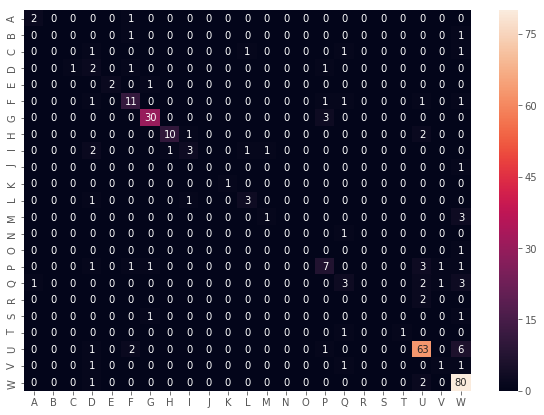

In [59]:
df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVW"],
                  columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVW"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Dealing with imbalance dataset
## Upsampling minority datapoints

In [171]:
df.label.value_counts()

30    347
28    270
8     151
6      69
20     50
10     42
21     41
1      38
15     28
12     20
4      18
16     12
29     10
22     10
3       9
9       7
26      6
5       6
24      5
2       4
18      3
14      3
17      2
19      2
25      2
7       2
11      2
13      1
23      1
27      1
Name: label, dtype: int64

In [174]:
# Separate majority and minority classes
df_majority = pd.concat([df[df.label==30], df[df.label==28], df[df.label==8], df[df.label==6]])

In [175]:
df_minority = df

In [176]:
df_minority = df_minority[df_minority.label != 30]
df_minority = df_minority[df_minority.label != 28]
df_minority = df_minority[df_minority.label != 8]
df_minority = df_minority[df_minority.label != 6]


In [177]:
list_ = df_minority.label.value_counts().to_dict()

In [178]:
keys = list(list_.keys())

In [179]:
from sklearn.utils import resample
# Upsample minority class
for i in range(len(keys)):
    count = list_[keys[i]]
    if count < 50:
        df_minority_upsampled = resample(df_minority[df_minority.label==keys[i]], 
                                         replace=True,     # sample with replacement
                                         n_samples=50,    # to match majority class
                                         random_state=123) # reproducible results
    df_majority = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_majority

Generated Balanced Dataset

In [216]:
print(df_upsampled.label.value_counts())
df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)

30    347
28    270
8     151
13    100
6      69
29     50
4      50
10     50
12     50
14     50
16     50
18     50
22     50
24     50
26     50
1      50
27     50
3      50
5      50
7      50
9      50
11     50
15     50
17     50
19     50
21     50
23     50
25     50
2      50
Name: label, dtype: int64


In [185]:
df_upsampled.head()

,label,keyword
0,8,"internet marketing,Internet Marketing,Networki..."
1,2,"design,Aerospace engineers research,develop ae..."
2,22,"marketing,management,sales,telesales,developme..."
3,15,good knowledge about Ceramics sanitaryware Bat...
4,30,"maintain the co,dination with ticketing system..."


Spilting into Training and Testing

In [186]:
x = df_upsampled['keyword'].values
y = df_upsampled['label'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))


vectorizer = CountVectorizer()
vectorizer.fit(x_train)


X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)


y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)


size of x_train (1602,), x_test (535,), y_train (1602,), y_test (535,)


### 7. Random Forest with Balanced Dataset

In [187]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
score = forest.score(X_test, y_test)

print("Accuracy of forest classifier:", round(score,4)*100)

Accuracy of forest classifier: 97.57000000000001


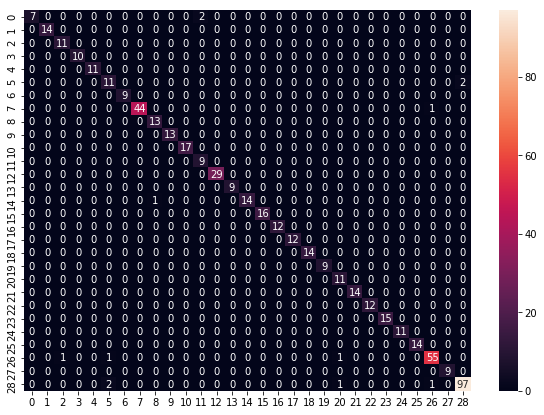

In [188]:
y_pred = forest.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### 8. Neural Network with Balanced dataset and text tokenization

In [189]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



Using TensorFlow backend.


In [198]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           64200     
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                175035    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1080      
Total params: 240,315
Trainable params: 240,315
Non-trainable params: 0
_________________________________________________________________


In [199]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 1602 samples, validate on 535 samples
Epoch 1/20
1602/1602 [==============================] - 1s 812us/step - loss: 0.2197 - acc: 0.9165 - val_loss: 0.1113 - val_acc: 0.9703
Epoch 2/20
1602/1602 [==============================] - 1s 523us/step - loss: 0.0865 - acc: 0.9735 - val_loss: 0.0630 - val_acc: 0.9796
Epoch 3/20
1602/1602 [==============================] - 1s 512us/step - loss: 0.0481 - acc: 0.9848 - val_loss: 0.0401 - val_acc: 0.9880
Epoch 4/20
1602/1602 [==============================] - 1s 503us/step - loss: 0.0272 - acc: 0.9923 - val_loss: 0.0273 - val_acc: 0.9925
Epoch 5/20
1602/1602 [==============================] - 1s 513us/step - loss: 0.0154 - acc: 0.9964 - val_loss: 0.0212 - val_acc: 0.9946
Epoch 6/20
1602/1602 [==============================] - 1s 502us/step - loss: 0.0090 - acc: 0.9984 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 7/20
1602/1602 [==============================] - 1s 538us/step - loss: 0.0054 - acc: 0.9994 - val_loss: 0.0185 - val_acc: 0.9952
E

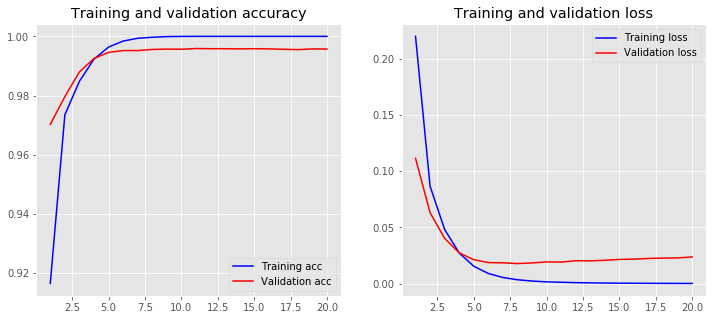

In [200]:
plot_history(history)

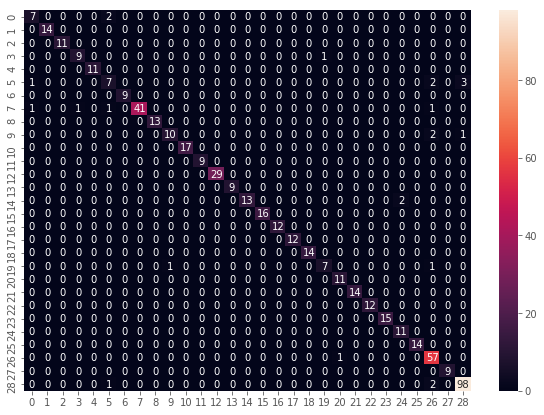

In [201]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Downsampling majority datapoints and upsampling minority datapoints

In [217]:
# Separate majority and minority classes
df_majority = pd.concat([df_upsampled[df_upsampled.label==30], df_upsampled[df_upsampled.label==28], df_upsampled[df_upsampled.label==8], df_upsampled[df_upsampled.label==6]])

df_minority = df_upsampled
df_minority = df_minority[df_minority.label != 30]
df_minority = df_minority[df_minority.label != 28]
df_minority = df_minority[df_minority.label != 8]
df_minority = df_minority[df_minority.label != 6]

In [218]:
df_majority.label.value_counts()

30    347
28    270
8     151
6      69
Name: label, dtype: int64

In [219]:
list_ = df_majority.label.value_counts().to_dict()
keys = list(list_.keys())

In [220]:
keys

[30, 28, 8, 6]

In [221]:
from sklearn.utils import resample
# Upsample minority class
for i in range(len(keys)):
    count = list_[keys[i]]
    if count >100:
        df_majority_downsampled = resample(df_majority[df_majority.label==keys[i]], 
                                         replace=False,     # sample with replacement
                                         n_samples=100,    # to match majority class
                                         random_state=123) # reproducible results
    df_minority = pd.concat([df_minority, df_majority_downsampled])
df_downsampled = df_minority

In [222]:
df_downsampled.label.value_counts()

8     200
30    100
28    100
13    100
14     50
2      50
3      50
4      50
5      50
7      50
9      50
10     50
11     50
12     50
15     50
29     50
16     50
17     50
18     50
19     50
21     50
22     50
23     50
24     50
25     50
26     50
27     50
1      50
Name: label, dtype: int64

In [223]:
x = df_downsampled['keyword'].values
y = df_downsampled['label'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))


vectorizer = CountVectorizer()
vectorizer.fit(x_train)


X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)


y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)


size of x_train (1275,), x_test (425,), y_train (1275,), y_test (425,)


### 9. Neural Network with Downsampled Majority class and Upsample minority classes

In [228]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           51700     
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 35)                175035    
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1080      
Total params: 227,815
Trainable params: 227,815
Non-trainable params: 0
_________________________________________________________________


In [229]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 1275 samples, validate on 425 samples
Epoch 1/20
1275/1275 [==============================] - 2s 1ms/step - loss: 2.9261 - acc: 0.2314 - val_loss: 1.9862 - val_acc: 0.4447
Epoch 2/20
1275/1275 [==============================] - 1s 486us/step - loss: 0.8542 - acc: 0.8157 - val_loss: 0.5648 - val_acc: 0.8635
Epoch 3/20
1275/1275 [==============================] - 1s 471us/step - loss: 0.2208 - acc: 0.9584 - val_loss: 0.3279 - val_acc: 0.9035
Epoch 4/20
1275/1275 [==============================] - 1s 485us/step - loss: 0.0837 - acc: 0.9922 - val_loss: 0.2440 - val_acc: 0.9294
Epoch 5/20
1275/1275 [==============================] - 1s 574us/step - loss: 0.0390 - acc: 0.9969 - val_loss: 0.1913 - val_acc: 0.9553
Epoch 6/20
1275/1275 [==============================] - 1s 487us/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.1900 - val_acc: 0.9459
Epoch 7/20
1275/1275 [==============================] - 1s 509us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.1772 - val_acc: 0.9576
Epo

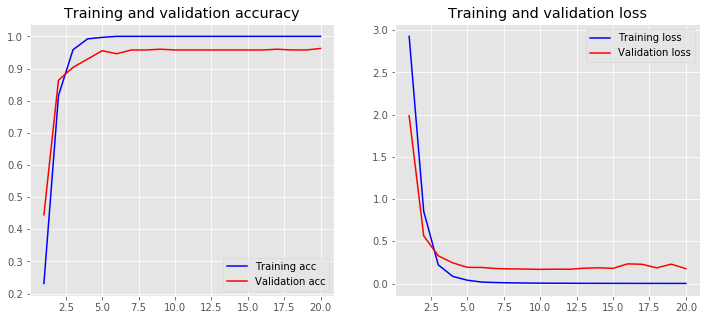

In [231]:
plot_history(history)

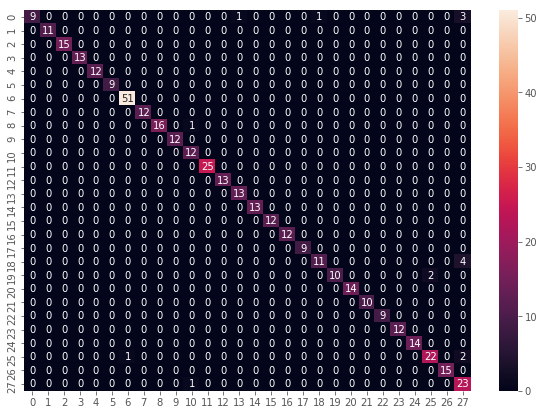

In [230]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Introducing Word Embedding from Glove
Using pre-trained weights

In [246]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [247]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B/glove.6B.50d.txt',
     tokenizer.word_index, embedding_dim)

In [253]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Ratio of nonzero elements in embedding matrix : %s'%(nonzero_elements / vocab_size), 'This means %s of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.'%(nonzero_elements*100 / vocab_size))


Ratio of nonzero elements in embedding matrix : 0.9264990328820116 This means 92.64990328820116 of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.


### 10. Neural Network without training of embedding matrix 
Glove word vector is used directly without any training

In [268]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_hot,
                    epochs=200,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 100, 50)           51700     
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 50)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 35)                1785      
_________________________________________________________________
dense_70 (Dense)             (None, 30)                1080      
Total params: 54,565
Trainable params: 2,865
Non-trainable params: 51,700
_________________________________________________________________
Train on 1275 samples, validate on 425 samples
Epoch 1/200
1275/1275 [==============================] - 3s 2ms/step - loss: 3.3711 - acc: 0.0816 - val_loss: 3.2579 - val_acc: 0.1153
Epoch 2/200
1275/1275 [==============================] - 0s 308us/step - loss: 3.205

Epoch 54/200
1275/1275 [==============================] - 0s 293us/step - loss: 0.5518 - acc: 0.8447 - val_loss: 0.6820 - val_acc: 0.7929
Epoch 55/200
1275/1275 [==============================] - 0s 345us/step - loss: 0.5451 - acc: 0.8455 - val_loss: 0.6580 - val_acc: 0.8047
Epoch 56/200
1275/1275 [==============================] - 0s 368us/step - loss: 0.5415 - acc: 0.8541 - val_loss: 0.6599 - val_acc: 0.7976
Epoch 57/200
1275/1275 [==============================] - 0s 317us/step - loss: 0.5335 - acc: 0.8533 - val_loss: 0.6547 - val_acc: 0.8094
Epoch 58/200
1275/1275 [==============================] - 0s 360us/step - loss: 0.5286 - acc: 0.8533 - val_loss: 0.6432 - val_acc: 0.8047
Epoch 59/200
1275/1275 [==============================] - 0s 340us/step - loss: 0.5224 - acc: 0.8557 - val_loss: 0.6399 - val_acc: 0.7976
Epoch 60/200
1275/1275 [==============================] - 0s 313us/step - loss: 0.5119 - acc: 0.8557 - val_loss: 0.6519 - val_acc: 0.8118
Epoch 61/200
1275/1275 [==========

1275/1275 [==============================] - 0s 290us/step - loss: 0.3114 - acc: 0.9075 - val_loss: 0.4290 - val_acc: 0.8894
Epoch 114/200
1275/1275 [==============================] - 0s 255us/step - loss: 0.2961 - acc: 0.9192 - val_loss: 0.4329 - val_acc: 0.8824
Epoch 115/200
1275/1275 [==============================] - 0s 250us/step - loss: 0.2958 - acc: 0.9200 - val_loss: 0.4093 - val_acc: 0.8965
Epoch 116/200
1275/1275 [==============================] - 0s 293us/step - loss: 0.2957 - acc: 0.9224 - val_loss: 0.4558 - val_acc: 0.8518
Epoch 117/200
1275/1275 [==============================] - 0s 254us/step - loss: 0.2950 - acc: 0.9216 - val_loss: 0.4571 - val_acc: 0.8376
Epoch 118/200
1275/1275 [==============================] - 0s 279us/step - loss: 0.2906 - acc: 0.9200 - val_loss: 0.4417 - val_acc: 0.8635
Epoch 119/200
1275/1275 [==============================] - 0s 251us/step - loss: 0.2854 - acc: 0.9255 - val_loss: 0.4036 - val_acc: 0.8941
Epoch 120/200
1275/1275 [================

1275/1275 [==============================] - 0s 302us/step - loss: 0.2018 - acc: 0.9427 - val_loss: 0.4041 - val_acc: 0.8965
Epoch 173/200
1275/1275 [==============================] - 0s 298us/step - loss: 0.2065 - acc: 0.9388 - val_loss: 0.3798 - val_acc: 0.9059
Epoch 174/200
1275/1275 [==============================] - 0s 257us/step - loss: 0.1993 - acc: 0.9396 - val_loss: 0.3706 - val_acc: 0.9129
Epoch 175/200
1275/1275 [==============================] - 0s 299us/step - loss: 0.1974 - acc: 0.9404 - val_loss: 0.4258 - val_acc: 0.8918
Epoch 176/200
1275/1275 [==============================] - 0s 291us/step - loss: 0.2076 - acc: 0.9420 - val_loss: 0.3725 - val_acc: 0.9082
Epoch 177/200
1275/1275 [==============================] - 0s 318us/step - loss: 0.2001 - acc: 0.9467 - val_loss: 0.3778 - val_acc: 0.9153
Epoch 178/200
1275/1275 [==============================] - 0s 314us/step - loss: 0.2002 - acc: 0.9396 - val_loss: 0.3861 - val_acc: 0.9035
Epoch 179/200
1275/1275 [================

In [269]:
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9592
Testing Accuracy:  0.9224


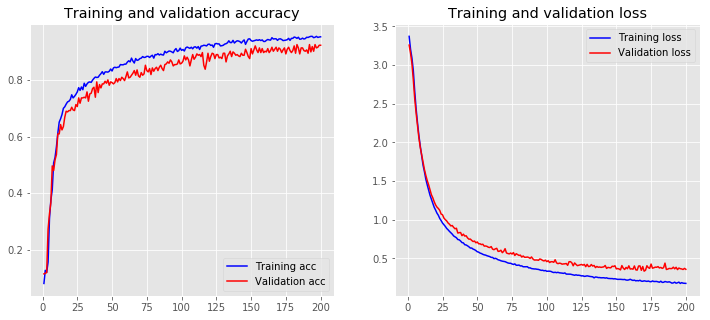

In [270]:
plot_history(history)


### 11. Neural Network with training of embedding matrix
Glove word vector is used with retraining with respect to currecnt dataset 

In [271]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_hot,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 100, 50)           51700     
_________________________________________________________________
global_max_pooling1d_32 (Glo (None, 50)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 35)                1785      
_________________________________________________________________
dense_72 (Dense)             (None, 30)                1080      
Total params: 54,565
Trainable params: 54,565
Non-trainable params: 0
_________________________________________________________________
Train on 1275 samples, validate on 425 samples
Epoch 1/50
1275/1275 [==============================] - 3s 2ms/step - loss: 3.2739 - acc: 0.0855 - val_loss: 3.1202 - val_acc: 0.1200
Epoch 2/50
1275/1275 [==============================] - 0s 377us/step - loss: 2.9713 - ac

Training Accuracy: 0.9929
Testing Accuracy:  0.9718


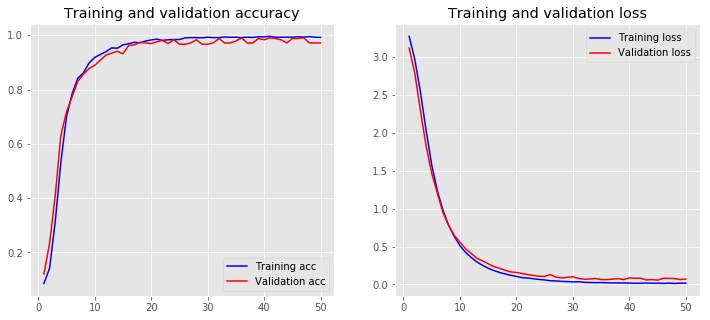

In [272]:
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

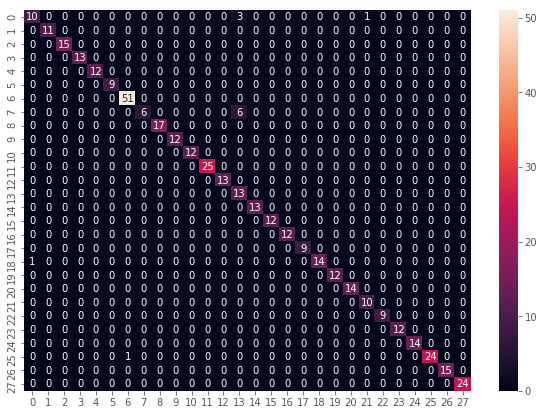

In [273]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. UnBalanced dataset may give wrong accuracy parameters as shown in section 1 to secton 6. By analyzing confusion matrix, it was clear that low frequency data is neglected and our algorithm is predicting most majority of class.
2. UnBalanced dataset need to Balanced first before doing any kind of analysis. Confusion matrix is a good matric to check the real accuracy of the algorithm
3. Linear classifier like Decision perform OK in this dataset but there is lot of scope of improvements
4. Neural Network started from pre-trained weight but not re-training is taking a much greater time in achieving similar accuracy as for re-training weights methodology
5. Neural Network started from pre-trained weight perform best in this case and obtained an accuracy of 97.18 in testing and confusion matrix is show at 273 line